In [23]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [105]:
img = Image.open('130Gyarados_Dream.png')
img = img.convert("RGBA")
datas = img.getdata()
newData = []
for item in datas:
    if item[3] == 0:
        newData.append((255, 255, 255, 255))
    else:
        newData.append(item)

img.putdata(newData)
img = img.convert("RGB")
img.save('arquivo.jpg')

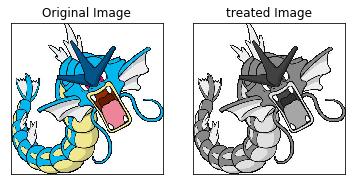

In [106]:
GAUSSIAN_KERNEL_SIZE = 3
GAUSSIAN_SIGMA = 0

DEFAULT_CANNY_SIGMA = 0.33
DEFAULT_IMAGES_TO_CHOOSE = 5

LOWER_SIGMA_THRESHOLD = 10
UPPER_SIGMA_THRESHOLD = 80

MAXIMUM_IMAGE_SIZE = 1920

arquivo = 'arquivo.jpg'

img = cv2.imread(arquivo, -1)

try:
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
except:
    pass

img2 = cv2.imread(arquivo, 0)

plt.subplot(121),plt.imshow(img, cmap = 'gray');
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2, cmap = 'gray')
plt.title('treated Image'), plt.xticks([]), plt.yticks([])
plt.show()

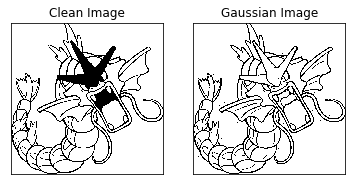

True

In [163]:
(thresh, im_bw) = cv2.threshold(img2, 110, 255, cv2.THRESH_BINARY)
th3 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,10)
#im_bw = cv2.resize(im_bw,(595, 842))


plt.subplot(121),plt.imshow(im_bw, cmap = 'gray');
plt.title('Clean Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(th3, cmap = 'gray');
plt.title('Gaussian Image'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('binary_image.bmp', im_bw)

In [164]:
!potrace -s binary_image.bmp -o teste.svg

In [165]:
import re
file = open('teste.svg', 'r')
paths = re.findall(r"<path [^>]*>", file.read())

In [166]:
newpaths = []
for path in paths:
    path_aux = path.replace('\n', ' ')
    path_aux = re.sub(r"<path.*d=\"", '',path_aux)
    path_aux = re.sub(r"\".*/>", '',path_aux)
    newpaths.append(path_aux)

final_path = []
for path in newpaths:
    path_aux = re.findall(r'([MmCcSsLlhHv][^MmCcSsLhlHv]*)', path)
    subpath = []
    for command in path_aux:
        command = command.strip()
        command = command.replace(',', ' ')
        command = command.replace('-', ' -')
        first_letter = command[0]
        last_letter = command[-1]
        command_aux = command.replace(first_letter, first_letter + ' ')
        if last_letter == 'z':
            command_aux = command_aux.replace(last_letter, ' ' + last_letter)
        command_aux = command_aux.strip()
        command_aux = re.split(r'\s+', command_aux)
        subpath.append(command_aux)
    final_path.append(subpath)

In [213]:
coordinates = []
for path in final_path:
    for command in path:
        if command[0] == 'c':
            if command[-1] == 'z':
                relative_points = [float(i) for i in command[1:-1]]
            else: 
                relative_points = [float(i) for i in command[1:]]
            x_2 = x
            y_2 = y
            for i in range(len(relative_points)//6):
                for t in np.arange(0,1.1,0.1):
                    x = x_2
                    y = y_2
                    x_1 = ((1-t)**3)*(x) + 3*((1-t)**2)*(t)*(x+relative_points[i*6]) + 3*((1-t))*(t**2)*(x+relative_points[i*6 + 2]) + (t**3)*(x+relative_points[i*6+4])
                    y_1 = ((1-t)**3)*(y) + 3*((1-t)**2)*(t)*(y+relative_points[i*6+1]) + 3*((1-t))*(t**2)*(y+relative_points[i*6+3]) + (t**3)*(y+relative_points[i*6+5])
                    y_1 = y_1
                    if(abs(x_1 - x) >= 2 or abs(y_1 - y) >= 2):
                        coordinates.append(['L', x_1, y_1])
                x_2 = x_1
                y_2 = y_1
                x = x_2
                y = y_1
            if command[-1] == 'z':
                x = x_init
                y = y_init
                coordinates.append(['L', x, y])

        elif command[0] == 'M':
            x = float(command[1])
            y = float(command[2])
            x_init = x
            y_init = y
            coordinates.append(['J', x, y])

        elif command[0] == 'm':
            x = x + float(command[1])
            y = y + float(command[2])
            x_init = x
            y_init = y
            coordinates.append(['J', x, y])

        elif command[0] == 'l':
            if command[-1] == 'z':
                relative_points = [float(i) for i in command[1:-1]]
            else: 
                relative_points = [float(i) for i in command[1:]]
            for i in range(len(relative_points)//2):
                x = x + float(relative_points[i*2])
                y = y + float(relative_points[i*2 + 1])
                coordinates.append(['L', x, y])
            if command[-1] == 'z':
                x = x_init
                y = y_init
                coordinates.append(['L', x, y])

        elif command[0] == 'h':
            x = x + float(command[1])
            y = y
            coordinates.append(['L', x, y])

        elif command[0] == 'H':
            x = float(command[1])
            y = y
            coordinates.append(['L', x, y])

        elif command[0] == 'v':
            x = x
            y = y + float(command[1])
            coordinates.append(['L', x, y])

In [214]:
df = pd.DataFrame(coordinates)

In [215]:
df[1] = df[1]/10
df[2] = df[2]/10

In [216]:
df.head()

0         1         2
0  J  163.0000  466.8000
1  L  163.0262  466.3553
2  L  163.1016  465.8104
3  L  163.2214  465.1791
4  L  163.3808  464.4752

In [217]:
f = open("arm_code.txt", "w")
for index, row in df.iterrows():
    if row[0] == 'L':
        f.write('MoveL Offs(p0,' + str(row[1]) + ',' + str(row[2]) + ', 0), v100, z5, tool0;\n')
    else:
        f.write('MoveJ Offs(p0,' + str(row[1]) + ',' + str(row[2]) + ', 10), v100, z1, tool0;\n')
f.close()

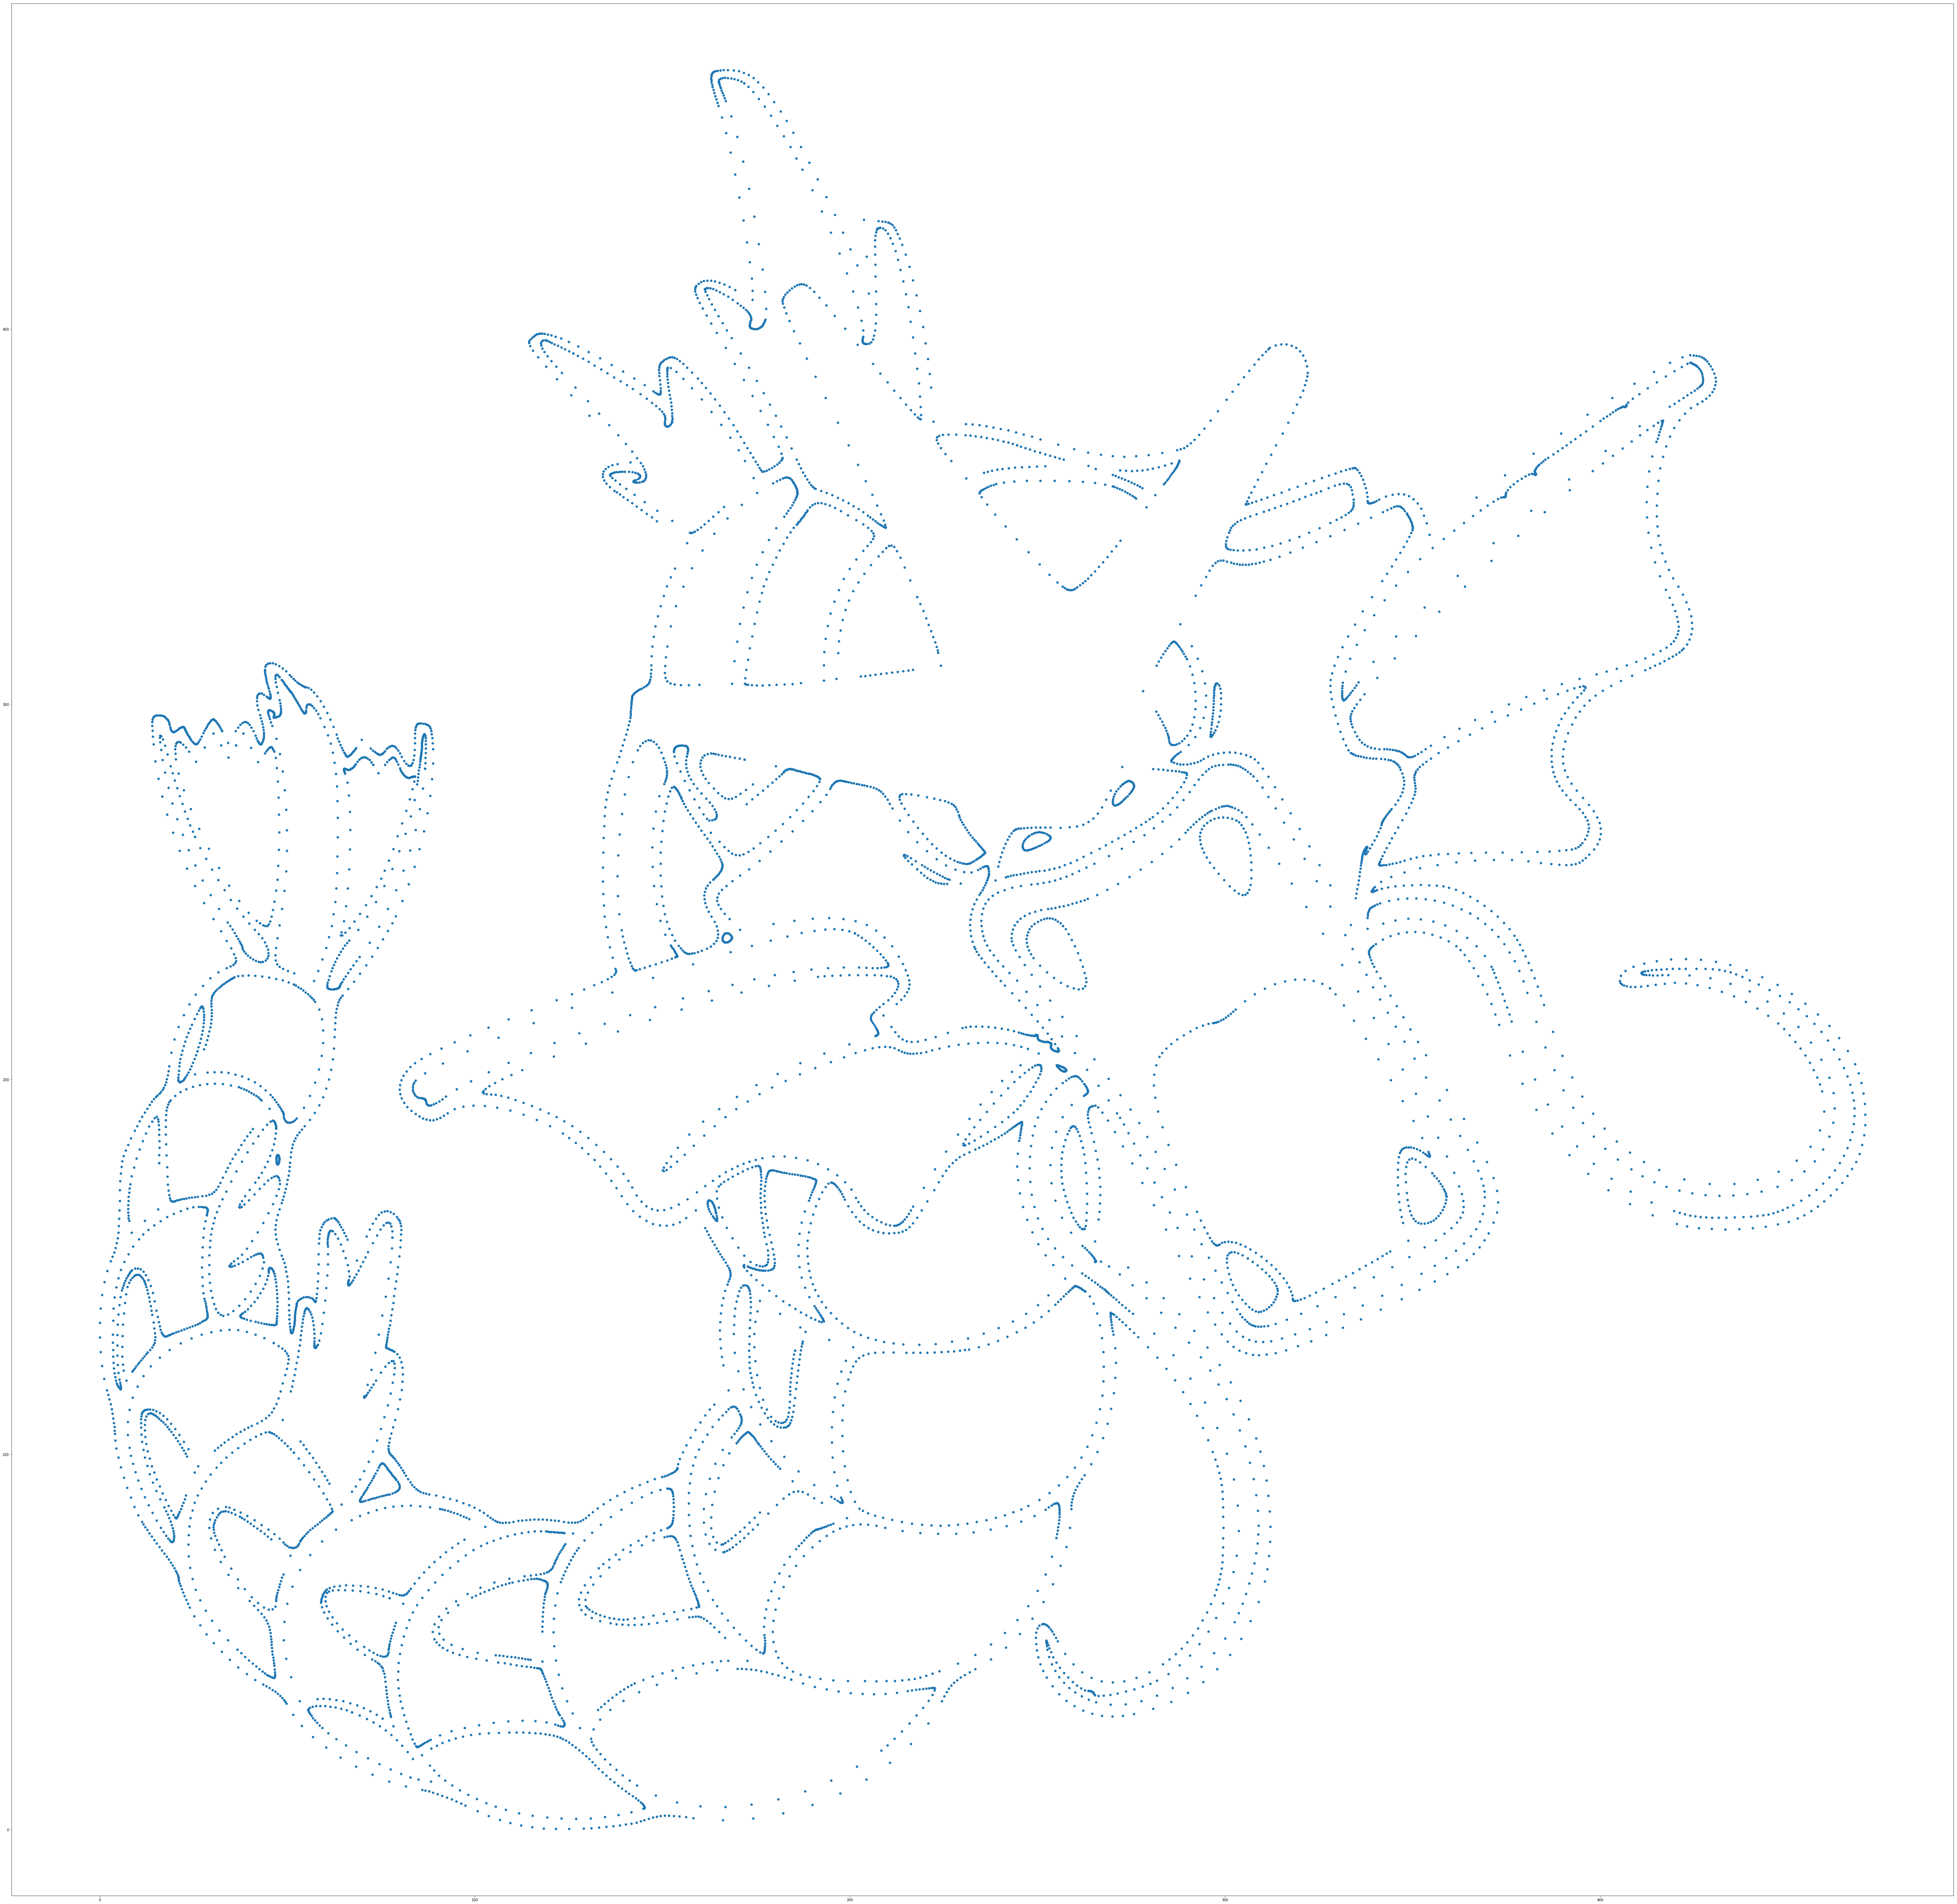

In [218]:
plt.figure(figsize = (100, 100))
plt.scatter(x = df[1], y = df[2])
plt.axis('equal');

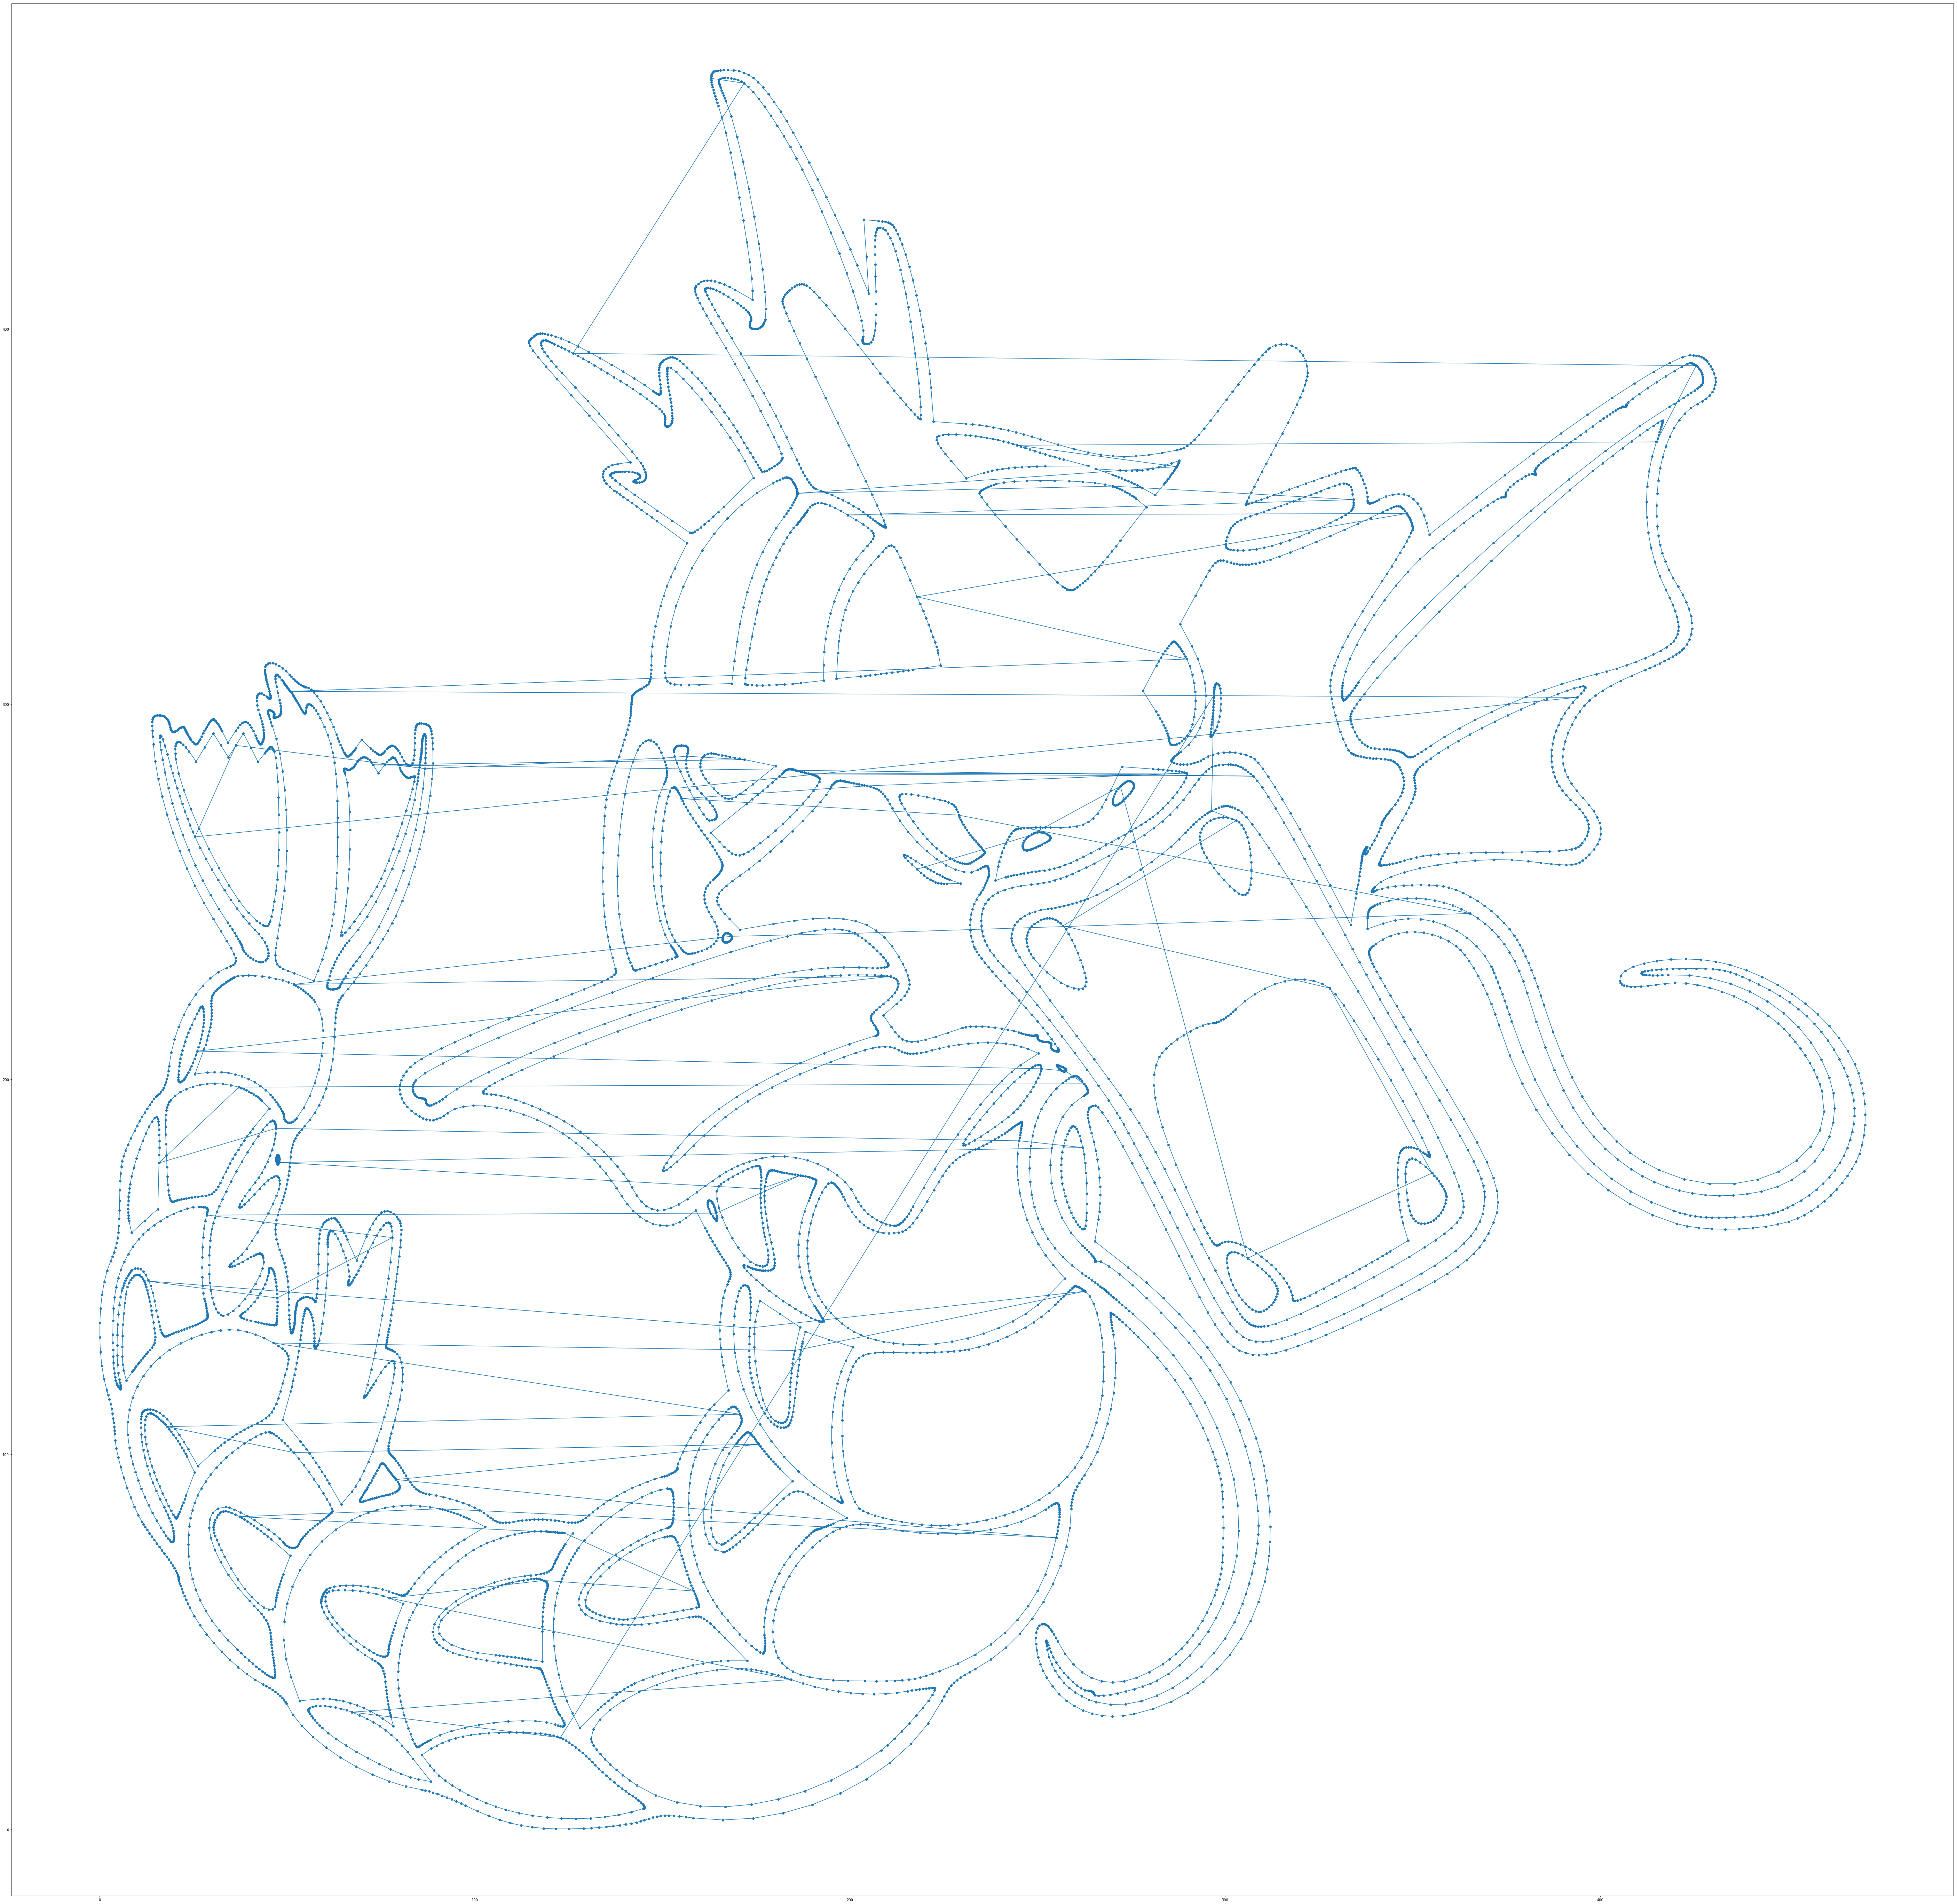

In [219]:
plt.figure(figsize = (100, 100))
plt.plot(df[1], df[2], '-o', )
plt.axis('equal')
plt.show()